<a href="https://colab.research.google.com/github/RahulbinAmin/RahulbinAmin/blob/main/Randomforestautoimun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RandomForestClasification for Autoimmune patient

##Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set style untuk visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

##Import data dari CSV

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Pmograman Menggunakan Pyton/archive (1)/export.csv")

## Data Cleaning

In [ ]:
df=df.drop_duplicates()

Menghapus baris dengan ID pengguna yang hilang

In [ ]:
df = df.dropna(subset=['user_id'])
df = df[(df['age'] >= 0) & (df['age'] <= 120)]
df['age'] = pd.to_numeric(df['age'], errors='coerce')

Kode saat ini hanya mengidentifikasi dan mencetak jumlah outlier ekstrem, yang merupakan langkah awal yang sangat baik dalam analisis data.

In [ ]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

extreme_outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]
print(f"Extreme age outliers ditemukan: {len(extreme_outliers)}")

Extreme age outliers ditemukan: 47235


Membersihkan Umur yang Outlier Dan Tidak mungkin

In [ ]:
df = df[(df['age'] >= max(0, lower_bound)) & (df['age'] <= min(120, upper_bound))]

In [ ]:
missing_age_count = df['age'].isnull().sum()
if missing_age_count > 0:
            # Group by country and sex untuk imputasi yang lebih akurat
    for country in df['country'].unique():
        for sex in df['sex'].unique():
            mask = (df['country'] == country) & (df['sex'] == sex) & df['age'].isnull()
            if mask.sum() > 0:
                # Gunakan median dari grup yang sama
                group_median = df[(df['country'] == country) & (df['sex'] == sex)]['age'].median()
                if pd.notna(group_median):
                    df.loc[mask, 'age'] = group_median
                else:
                     # Fallback ke median global
                    df.loc[mask, 'age'] = df['age'].median()

print(f" Setelah pembersihan age: {len(df)} baris, missing: {df['age'].isnull().sum()}")

 Setelah pembersihan age: 7618411 baris, missing: 0


In [ ]:
#cleaning tanggal
df['checkin_date'] = pd.to_datetime(df['checkin_date'], errors='coerce')
earliest_date = pd.Timestamp('2000-01-01')

In [ ]:
#pembersihan sex
df['sex'].fillna(df['sex'].mode()[0] if not df['sex'].mode().empty else 'UNKNOWN', inplace=True)

In [ ]:
#pembersihan country
df['country'] = df['country'].astype(str).str.upper().str.strip()
df['country'] = df['country'].replace(['NAN', 'NULL', 'NONE', ''], 'UNKNOWN')

In [ ]:
df['trackable_value'] = pd.to_numeric(df['trackable_value'], errors='coerce')

# Filter values between -50 and 50
df['trackable_value'] = df['trackable_value'].apply(lambda x: x if -50 <= x <= 50 else np.nan)

# Fill missing values with the mean
mean_trackable_value = df['trackable_value'].mean()
df['trackable_value'].fillna(mean_trackable_value, inplace=True)

print(f"missing: {df['trackable_value'].isnull().sum()}")

missing: 0


In [ ]:
# prompt: Hapus setiap baris yang trackable_namenya missing

df = df.dropna(subset=['trackable_name'])

In [ ]:
# prompt: Total trackable_type

df['trackable_type'].value_counts()

,count
trackable_type,
Symptom,3487201
Weather,1321824
Condition,1064815
Treatment,871974
Food,452873
Tag,419564
HBI,156


In [ ]:
# prompt: cek kolom yang missing
df.isnull().sum()

,0
user_id,0
age,0
sex,0
country,0
checkin_date,0
trackable_id,0
trackable_type,0
trackable_name,0
trackable_value,0


## Tranformasi Data

Untuk Melihat Grup Gender Berdasarkan kategori Usia

In [ ]:
#Transformasi Umur menurut kategori
# Membuat kategori usia
bins = [0, 1, 12, 19, 35, 60, 120]
labels = ['Bayi', 'Anak-anak', 'Remaja', 'Dewasa Muda', 'Dewasa', 'Lanjut Usia']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True, include_lowest=True)

##Visualisasi Data

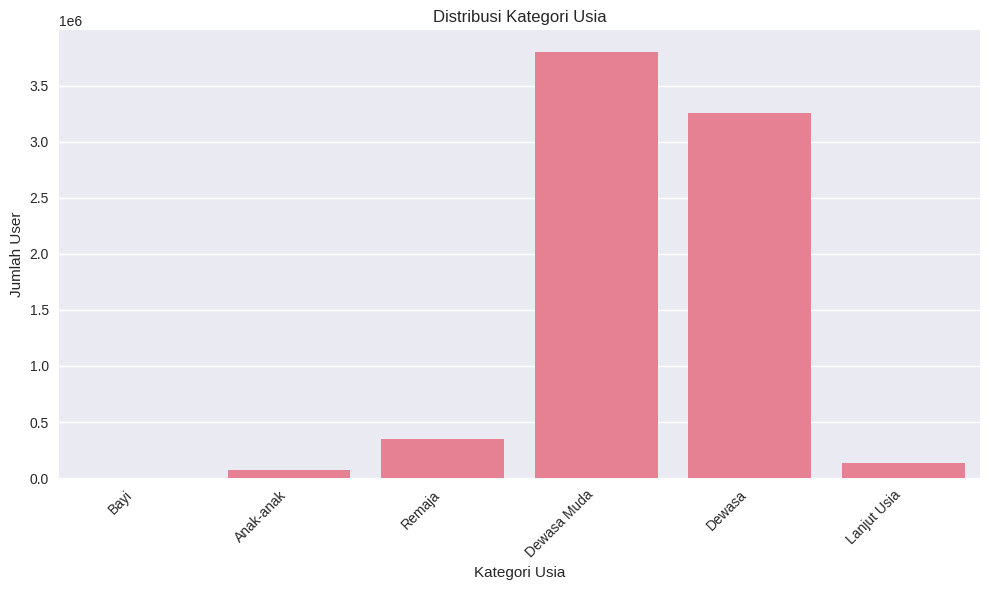

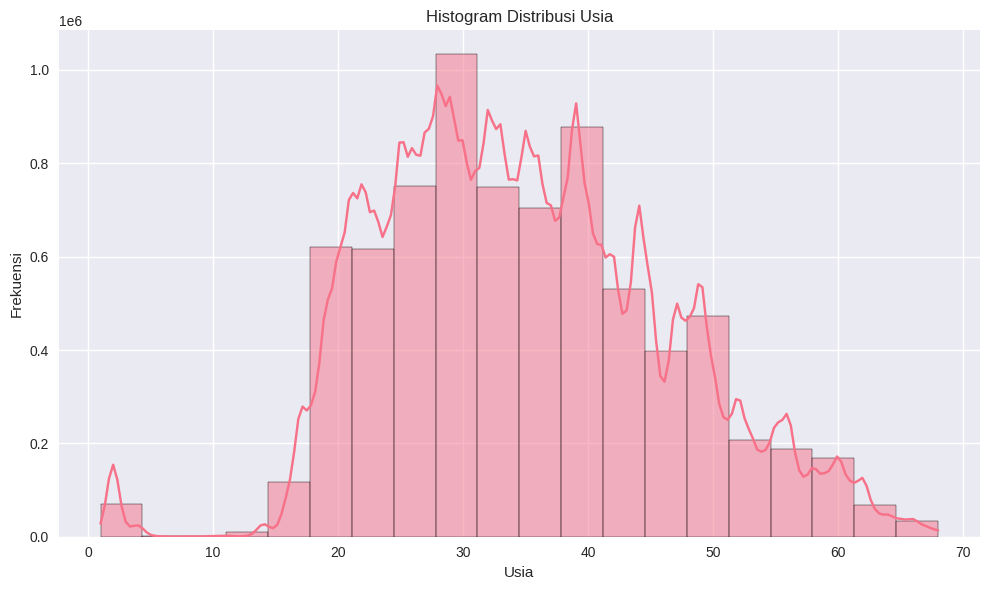

In [ ]:
# Menghitung jumlah user per kategori usia
age_group_counts = df['age_group'].value_counts().reindex(labels)

# Visualisasi distribusi usia
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values)
plt.title('Distribusi Kategori Usia')
plt.xlabel('Kategori Usia')
plt.ylabel('Jumlah User')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualisasi histogram usia
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Histogram Distribusi Usia')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

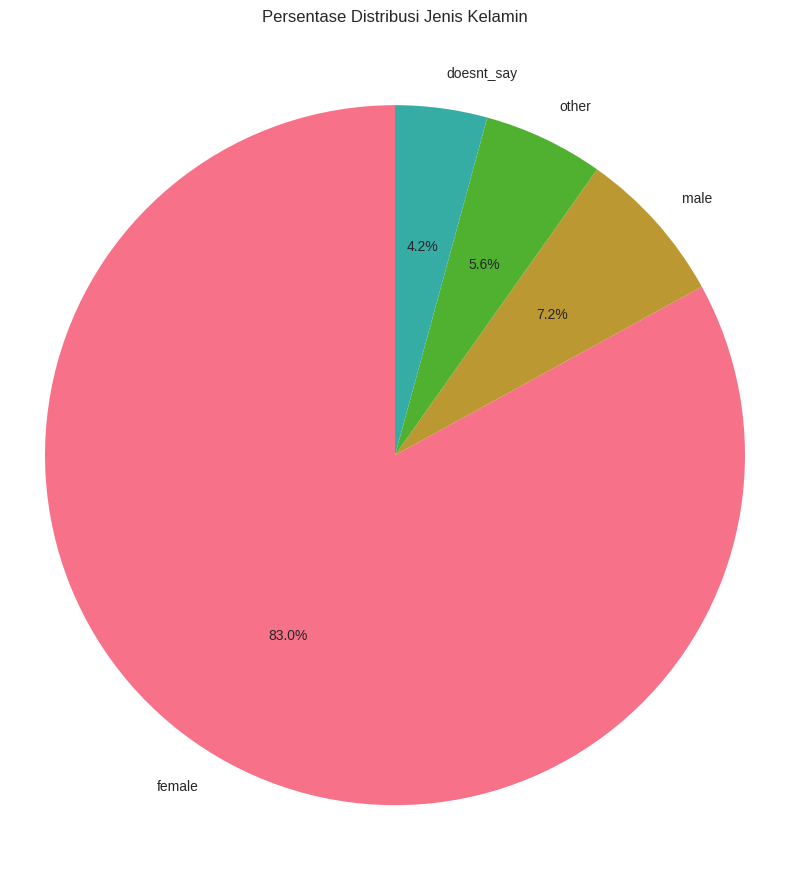

In [ ]:
#Visualisasikan untuk gender
sex_counts = df['sex'].value_counts()


# Visualisasi pie chart jenis kelamin
plt.figure(figsize=(8, 9))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Persentase Distribusi Jenis Kelamin')
plt.axis('equal') # Memastikan pie chart berbentuk lingkaran
plt.tight_layout()
plt.show()

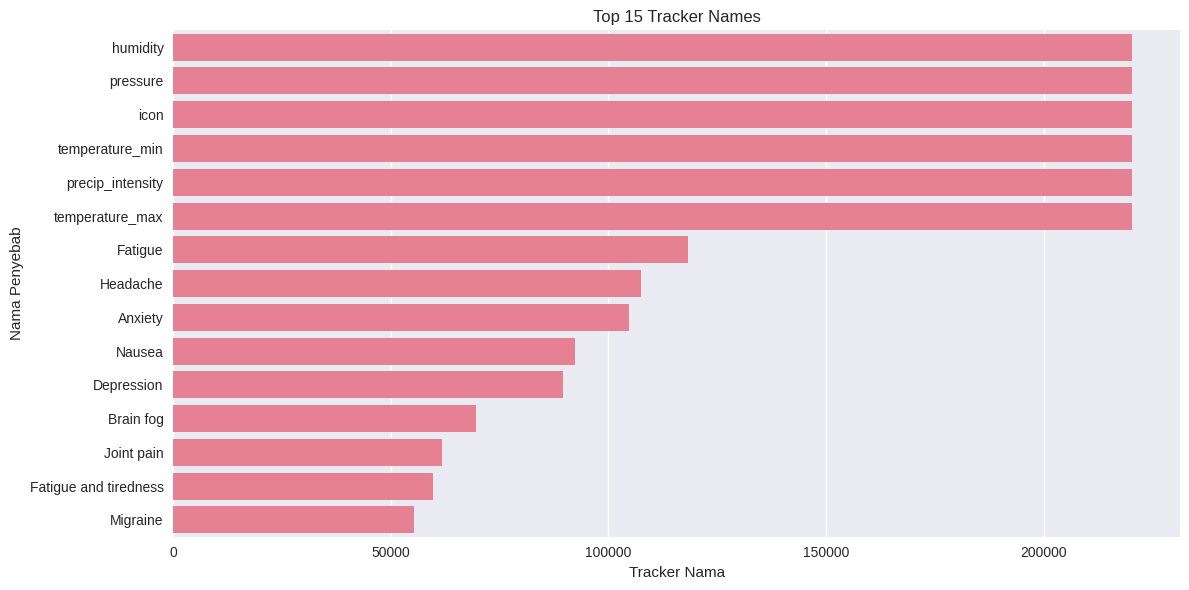

In [ ]:
# Hitung jumlah kemunculan setiap tracker_name
tracker_name_counts = df['trackable_name'].value_counts().nlargest(15)

# Visualisasi 10 tracker_name teratas
plt.figure(figsize=(12, 6))
sns.barplot(x=tracker_name_counts.values, y=tracker_name_counts.index)
plt.title('Top 15 Tracker Names')
plt.xlabel('Tracker Nama')
plt.ylabel('Nama Penyebab')
plt.tight_layout()
plt.show()

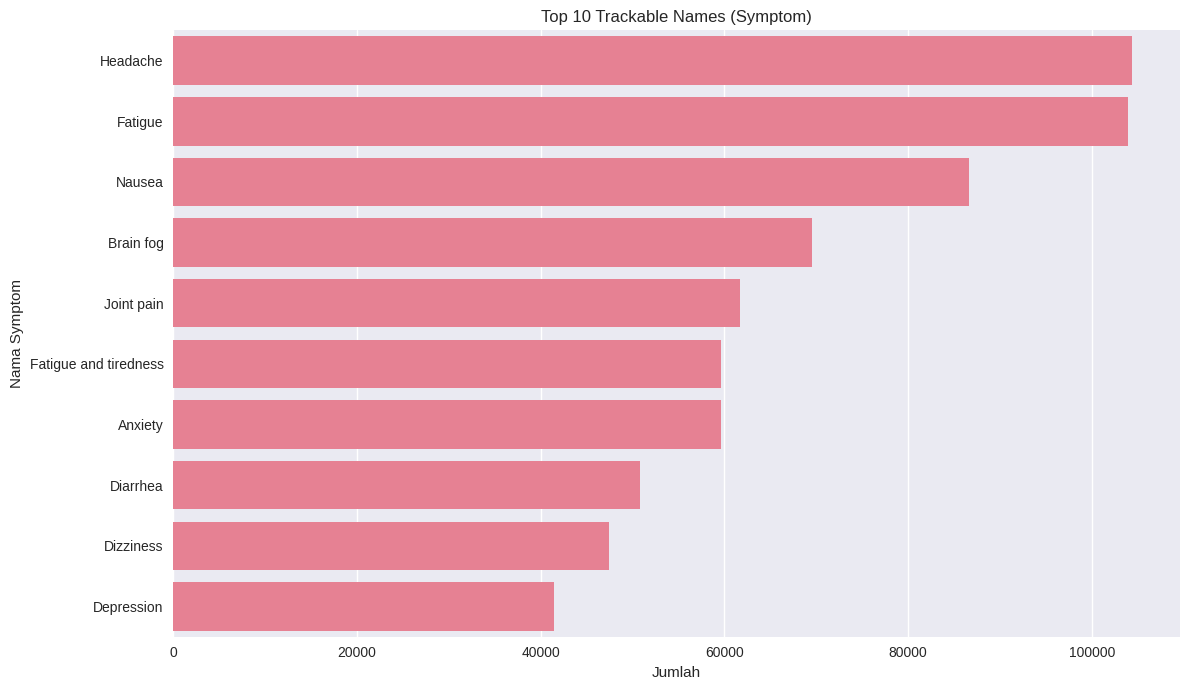

In [ ]:
symptom_df = df[df['trackable_type'] == 'Symptom']
symptom_name_distribution = symptom_df['trackable_name'].value_counts()
# Opsional: Visualisasi distribusi 10 symptom teratas
if len(symptom_name_distribution) > 0:
    plt.figure(figsize=(12, 7))
    sns.barplot(x=symptom_name_distribution.head(10).values, y=symptom_name_distribution.head(10).index)
    plt.title('Top 10 Trackable Names (Symptom)')
    plt.xlabel('Jumlah')
    plt.ylabel('Nama Symptom')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data 'Symptom' yang ditemukan untuk dianalisis.")

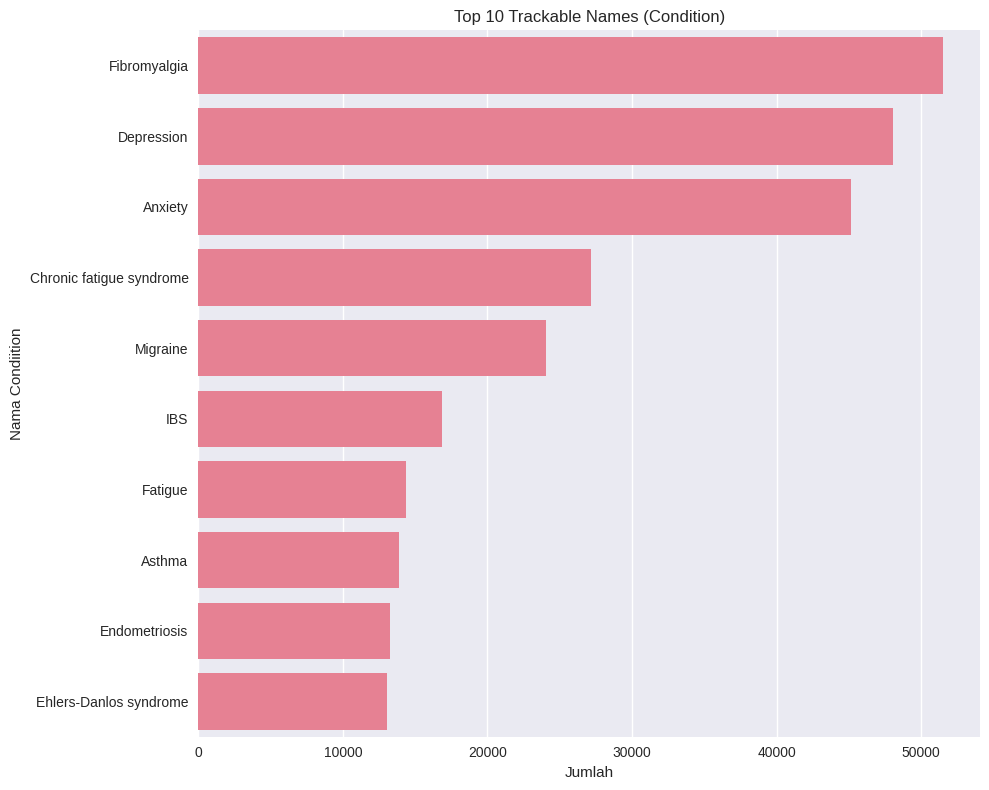

In [ ]:
# Filter baris di mana trackable_type adalah 'Condition'
co_df = df[df['trackable_type'] == 'Condition']

# Hitung distribusi (jumlah kemunculan) untuk trackable_name di baris 'Condition'
Condisi_name_distribution = co_df['trackable_name'].value_counts()

# Opsional: Visualisasi distribusi 10 symptom teratas
if len(Condisi_name_distribution) > 0:
    plt.figure(figsize=(10, 8))
    sns.barplot(x=Condisi_name_distribution.head(10).values, y=Condisi_name_distribution.head(10).index)
    plt.title('Top 10 Trackable Names (Condition)')
    plt.xlabel('Jumlah')
    plt.ylabel('Nama Condiition')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data 'Condition' yang ditemukan untuk dianalisis.")

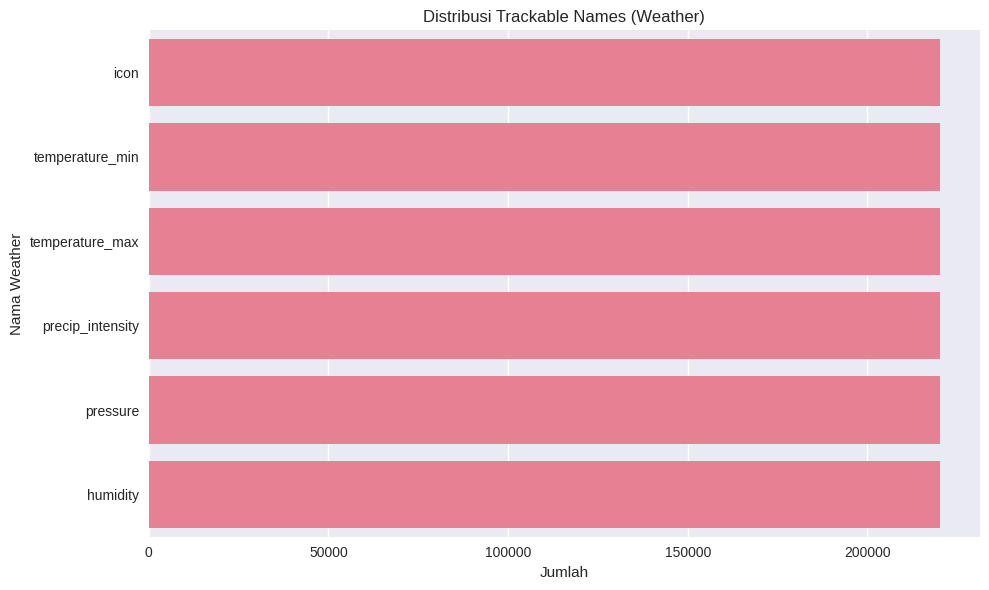

In [ ]:
weather_df = df[df['trackable_type'] == 'Weather']
weather_name_distribution = weather_df['trackable_name'].value_counts()
# Visualisasi distribusi weather
if len(weather_name_distribution) > 0:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=weather_name_distribution.values, y=weather_name_distribution.index)
    plt.title('Distribusi Trackable Names (Weather)')
    plt.xlabel('Jumlah')
    plt.ylabel('Nama Weather')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data 'Weather' yang ditemukan untuk dianalisis.")

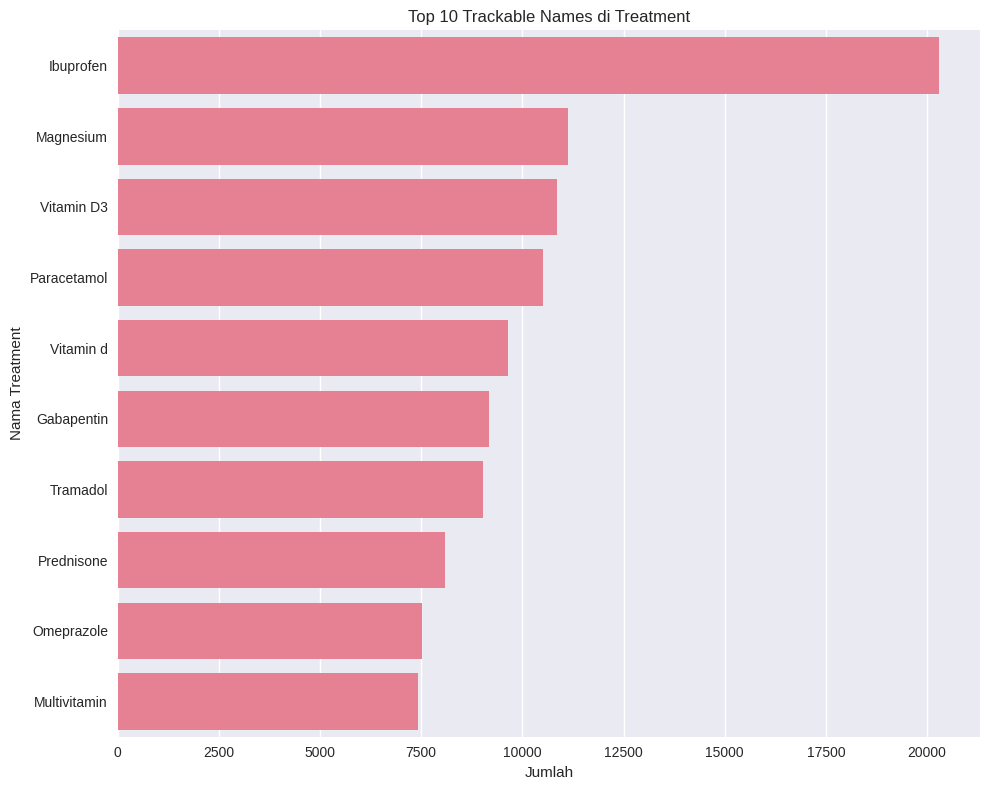

In [ ]:
treat_df = df[df['trackable_type'] == 'Treatment']

# Hitung distribusi (jumlah kemunculan) untuk trackable_name di baris 'Treatment'
treat_name_distribution = treat_df['trackable_name'].value_counts()

# Visualisasi distribusi Treatment
if len(treat_name_distribution) > 0:
    plt.figure(figsize=(10, 8))
    sns.barplot(x=treat_name_distribution.head(10).values, y=treat_name_distribution.head(10).index)
    plt.title('Top 10 Trackable Names di Treatment')
    plt.xlabel('Jumlah')
    plt.ylabel('Nama Treatment')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data 'Treatment' yang ditemukan untuk dianalisis.")

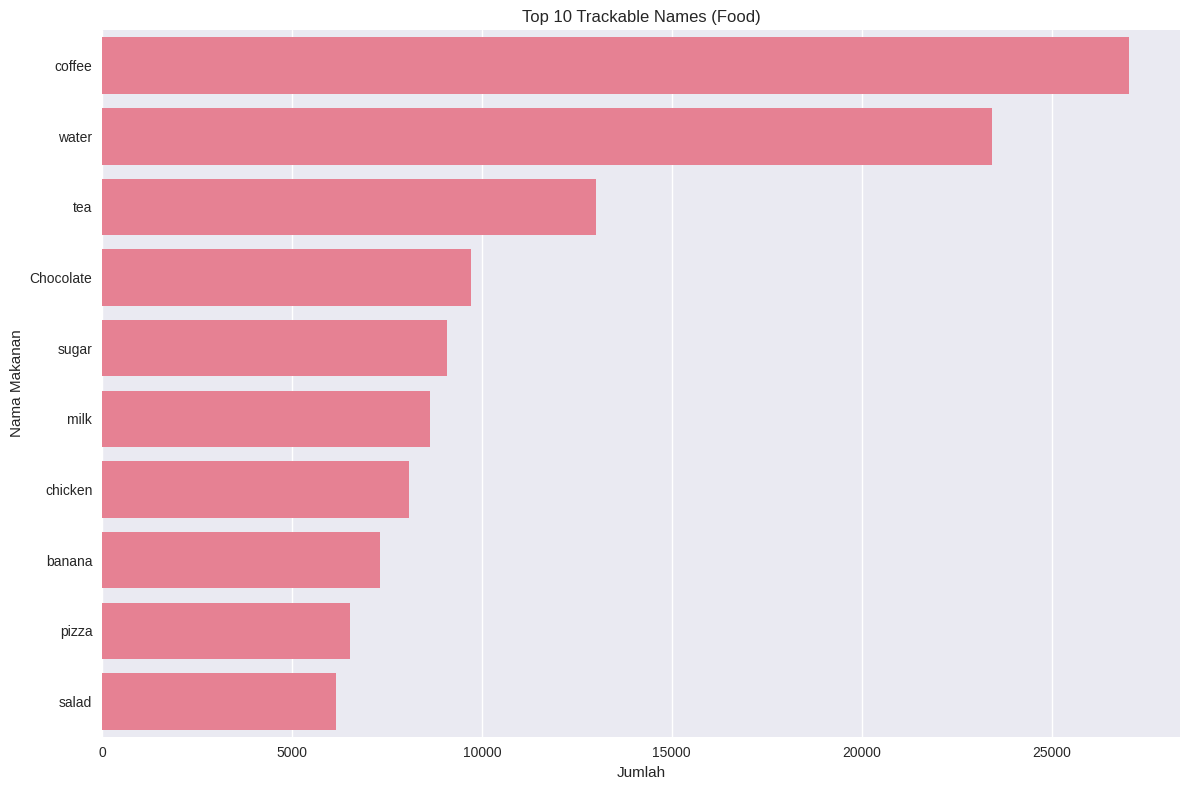

In [ ]:
food_df = df[df['trackable_type'] == 'Food']

# Hitung distribusi (jumlah kemunculan) untuk trackable_name di baris 'Food'
food_name_distribution = food_df['trackable_name'].value_counts()

# Visualisasi distribusi Food (Top 10 atau semua jika kurang dari 10)
if len(food_name_distribution) > 0:
    plt.figure(figsize=(12, 8))
    # Ambil top 10 jika lebih dari 10, jika tidak ambil semua
    top_food = food_name_distribution.head(10) if len(food_name_distribution) > 10 else food_name_distribution
    sns.barplot(x=top_food.values, y=top_food.index)
    plt.title(f'Top {len(top_food)} Trackable Names (Food)')
    plt.xlabel('Jumlah')
    plt.ylabel('Nama Makanan')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data 'Food' yang ditemukan untuk dianalisis.")

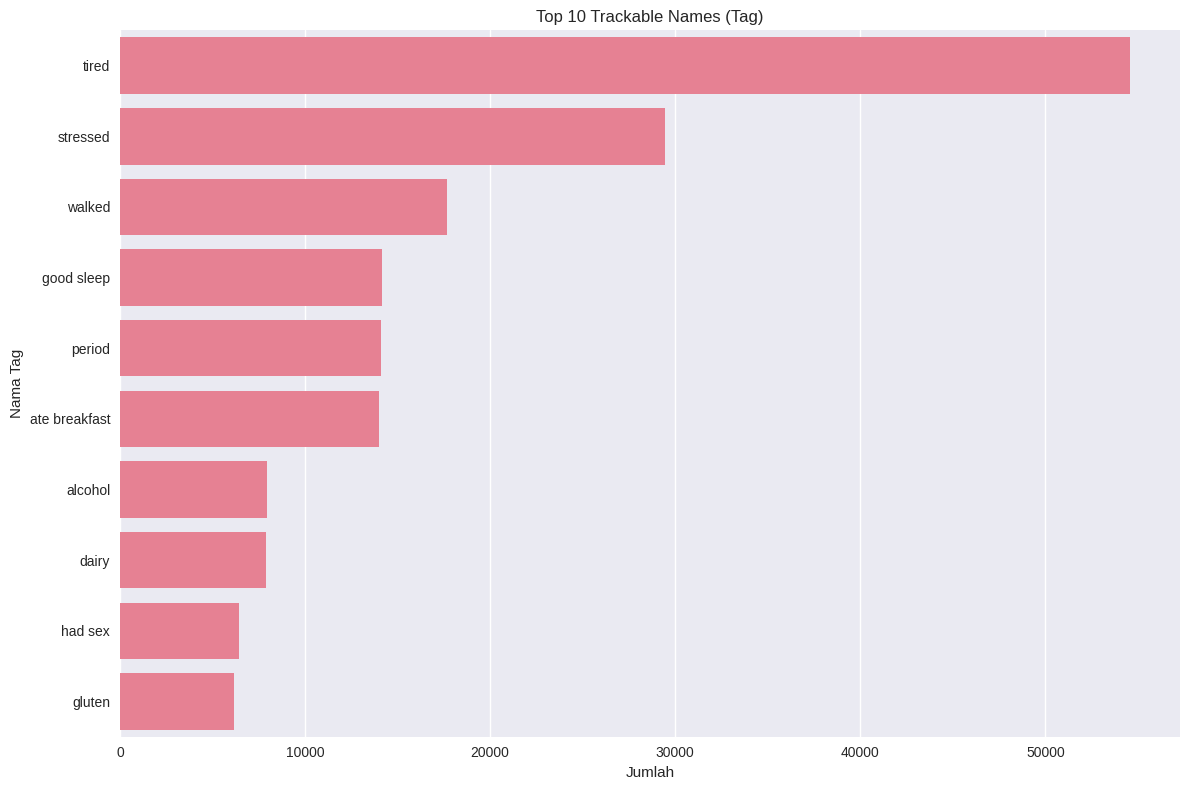

In [ ]:
tag_df = df[df['trackable_type'] == 'Tag']

# Hitung distribusi (jumlah kemunculan) untuk trackable_name di baris 'Tag'
tag_name_distribution = tag_df['trackable_name'].value_counts()

# Visualisasi distribusi Tag (Top 10 atau semua jika kurang dari 10)
if len(tag_name_distribution) > 0:
    plt.figure(figsize=(12, 8))
    # Ambil top 10 jika lebih dari 10, jika tidak ambil semua
    top_tag = tag_name_distribution.head(10) if len(tag_name_distribution) > 10 else tag_name_distribution
    sns.barplot(x=top_tag.values, y=top_tag.index)
    plt.title(f'Top {len(top_tag)} Trackable Names (Tag)')
    plt.xlabel('Jumlah')
    plt.ylabel('Nama Tag')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data 'Tag' yang ditemukan untuk dianalisis.")

##Explorasi Data Analisis

#Model Random Forest

Membuat Feature untuk memudah model membaca data

In [ ]:
df['checkin_day'] = df['checkin_date'].dt.day
df['checkin_month'] = df['checkin_date'].dt.month
df['checkin_weekday'] = df['checkin_date'].dt.weekday

**Rentan Nilai Tingkat Gejala**

In [ ]:
df_symptom = df[df['trackable_type'] == 'Symptom']

# Hitung rentang nilai (min dan max) dari 'trackable_value' untuk tipe SYMPTOM
if not df_symptom.empty:
    min_value = df_symptom['trackable_value'].min()
    max_value = df_symptom['trackable_value'].max()
    print(f"Rentang nilai 'trackable_value' untuk 'trackable_type' == 'SYMPTOM': {min_value} - {max_value}")
else:
    print("Tidak ada data dengan 'trackable_type' == 'SYMPTOM' ditemukan.")

Rentang nilai 'trackable_value' untuk 'trackable_type' == 'SYMPTOM': 0.0 - 4.0


In [ ]:
def create_healthcare_quality_feature(df):
    df = df.copy()
    healthcare_quality_map = {
        'US': 0.85, 'CA': 0.90, 'UK': 0.88, 'GE': 0.89,
        'FR': 0.87, 'IT': 0.85, 'SP': 0.86, 'NE': 0.91,
        'AU': 0.92, 'NZ': 0.91, 'JPN': 0.90, 'SK': 0.89,
        'SG': 0.87, 'IND': 0.65, 'PK': 0.87,
    }
    # Mengubah kolom 'country' menjadi string dan uppercase untuk penyesuaian dengan map
    df['country_upper'] = df['country'].astype(str).str.upper().str.strip()
    df['healthcare_quality'] = df['country_upper'].map(healthcare_quality_map).fillna(0.5)
    return df

# Contoh penggunaan fungsi pada DataFrame 'df' yang sudah ada
df_with_healthcare_quality = create_healthcare_quality_feature(df.copy())

Total data symptom: 3,487,201 records
Unique symptoms: 22332
Unique users: 34391


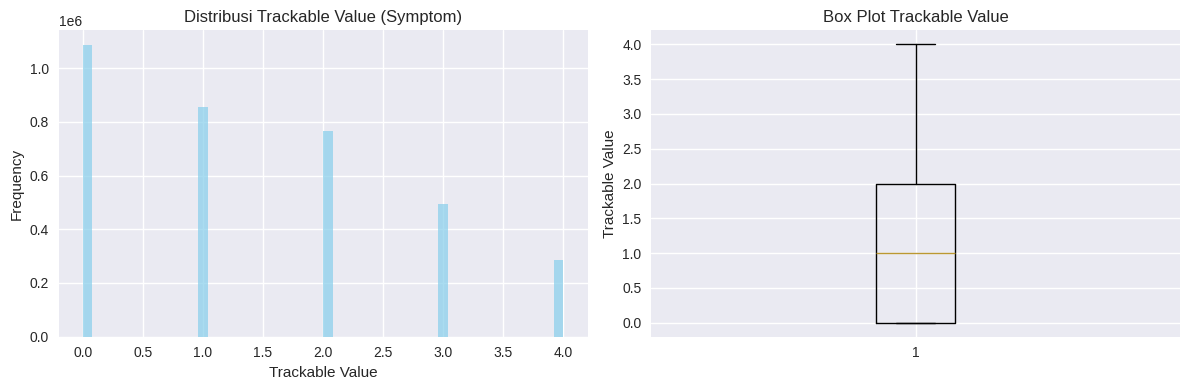

Statistik Trackable Value:
count    3.487201e+06
mean     1.437710e+00
std      1.282264e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.000000e+00
Name: trackable_value, dtype: float64


In [ ]:



from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# ===== 1. FOKUS PADA DATA SYMPTOM =====
# Filter hanya data symptom
symptom_df = df[df['trackable_type'] == 'Symptom'].copy()
print(f"Total data symptom: {len(symptom_df):,} records")
print(f"Unique symptoms: {symptom_df['trackable_name'].nunique()}")
print(f"Unique users: {symptom_df['user_id'].nunique()}")

symptom_df = create_healthcare_quality_feature(symptom_df)
# ===== 2. ANALISIS DISTRIBUSI TRACKABLE_VALUE =====
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(symptom_df['trackable_value'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribusi Trackable Value (Symptom)')
plt.xlabel('Trackable Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(symptom_df['trackable_value'])
plt.title('Box Plot Trackable Value')
plt.ylabel('Trackable Value')

plt.tight_layout()
plt.show()

print(f"Statistik Trackable Value:")
print(symptom_df['trackable_value'].describe())

# ===== 3. MEMBUAT KATEGORI SEVERITY =====
def create_severity_categories(df):
    # Metode 1: Berdasarkan quartile
    q25 = df['trackable_value'].quantile(0.25)
    q75 = df['trackable_value'].quantile(0.75)

    def categorize_severity_quartile(value):
        if value <= q25:
            return 'Ringan'
        elif value <= q75:
            return 'Sedang'
        else:
            return 'Berat'

    # Metode 2: Berdasarkan domain knowledge (0-10 scale typical untuk symptom)
    def categorize_severity_medical(value):
        if value <= 1.5:
            return 'Ringan'
        elif value <= 2.5:
            return 'Sedang'
        else:
            return 'Berat'

    # Gunakan metode medical yang lebih interpretable
    df['severity_category'] = df['trackable_value'].apply(categorize_severity_medical)

    return df

symptom_df = create_severity_categories(symptom_df)

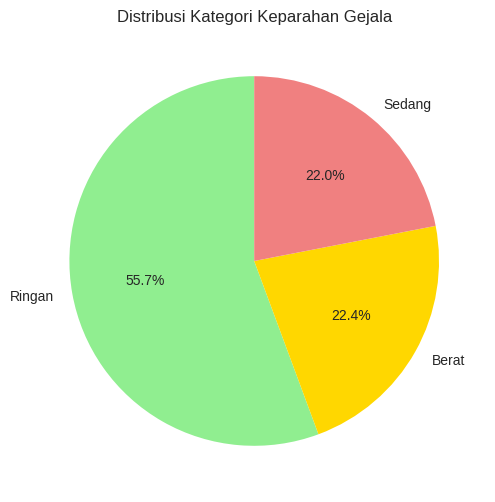

Distribusi Severity Category:
severity_category
Ringan    1940696
Berat      780942
Sedang     765563
Name: count, dtype: int64


In [ ]:
# Visualisasi distribusi severity
plt.figure(figsize=(10, 6))
severity_counts = symptom_df['severity_category'].value_counts()
colors = ['lightgreen', 'gold', 'lightcoral']
plt.pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Distribusi Kategori Keparahan Gejala')
plt.show()

print("Distribusi Severity Category:")
print(symptom_df['severity_category'].value_counts())

In [ ]:
# ===== 4. FEATURE ENGINEERING =====
print("\n🔧 FEATURE ENGINEERING")
print("="*40)

# 4.1 User-level aggregated features
print("📈 Membuat user-level features...")
user_symptom_stats = symptom_df.groupby('user_id').agg({
    'trackable_value': ['mean', 'std', 'count', 'max', 'min'],
    'trackable_name': 'nunique',
    'checkin_date': [lambda x: (x.max() - x.min()).days, 'count']
}).reset_index()

# Flatten column names
user_symptom_stats.columns = ['user_id', 'avg_severity', 'std_severity', 'symptom_count',
                             'max_severity', 'min_severity', 'unique_symptoms',
                             'tracking_duration_days', 'checkin_frequency']

# Fill NaN in std_severity (when user has only 1 record)
user_symptom_stats['std_severity'].fillna(0, inplace=True)

# 4.2 Symptom-specific features
print("🧬 Membuat symptom-specific features...")
symptom_stats = symptom_df.groupby('trackable_name').agg({
    'trackable_value': ['mean', 'std', 'count']
}).reset_index()

symptom_stats.columns = ['trackable_name', 'symptom_avg_severity',
                        'symptom_std_severity', 'symptom_frequency']
symptom_stats['symptom_std_severity'].fillna(0, inplace=True)

# 4.3 Temporal features
print("📅 Membuat temporal features...")
symptom_df['is_weekend'] = symptom_df['checkin_weekday'].isin([5, 6]).astype(int)
symptom_df['season'] = symptom_df['checkin_month'].apply(lambda x:
    0 if x in [12,1,2] else  # Winter
    1 if x in [3,4,5] else   # Spring
    2 if x in [6,7,8] else   # Summer
    3)                       # Fall

# 4.4 Merge all features
print("🔗 Menggabungkan semua features...")
# Merge user stats
symptom_df = symptom_df.merge(user_symptom_stats, on='user_id', how='left')

# Merge symptom stats
symptom_df = symptom_df.merge(symptom_stats, on='trackable_name', how='left')

print(f"✅ Feature engineering selesai. Shape: {symptom_df.shape}")



🔧 FEATURE ENGINEERING
📈 Membuat user-level features...
🧬 Membuat symptom-specific features...
📅 Membuat temporal features...
🔗 Menggabungkan semua features...
✅ Feature engineering selesai. Shape: (3487201, 29)


In [ ]:
# ===== 5. PERSIAPAN DATA UNTUK MODELING =====
print("\n📋 PERSIAPAN DATA UNTUK MODELING")
print("="*45)

# Encode categorical variables
label_cols = ['sex', 'trackable_name','country','age_group']
le_dict = {}

for col in label_cols:
    le = LabelEncoder()
    symptom_df[f'{col}_encoded'] = le.fit_transform(symptom_df[col].astype(str))
    le_dict[col] = le

# Select features for modeling
feature_columns = [
    # Demographic features
    'age', 'sex_encoded','age_group_encoded','healthcare_quality',

    # Symptom-specific features
    'trackable_name_encoded', 'symptom_avg_severity', 'symptom_std_severity', 'symptom_frequency',

    # User-level features
    'avg_severity', 'std_severity', 'symptom_count', 'max_severity', 'min_severity',
    'unique_symptoms', 'tracking_duration_days', 'checkin_frequency',

    # Temporal features
    'checkin_day', 'checkin_month', 'checkin_weekday','season'
]

# Prepare X and y
X = symptom_df[feature_columns].copy()
y_classification = symptom_df['severity_category'].copy()  # For classification

# Handle any remaining missing values
X = X.fillna(X.median())

print(f"Features yang digunakan: {len(feature_columns)}")
print(f"Total samples: {len(X):,}")
print(f"Feature names: {feature_columns}")


📋 PERSIAPAN DATA UNTUK MODELING
Features yang digunakan: 20
Total samples: 3,487,201
Feature names: ['age', 'sex_encoded', 'age_group_encoded', 'healthcare_quality', 'trackable_name_encoded', 'symptom_avg_severity', 'symptom_std_severity', 'symptom_frequency', 'avg_severity', 'std_severity', 'symptom_count', 'max_severity', 'min_severity', 'unique_symptoms', 'tracking_duration_days', 'checkin_frequency', 'checkin_day', 'checkin_month', 'checkin_weekday', 'season']



🤖 MEMBANGUN MODEL KLASIFIKASI
✅ Data split - Train: 2,789,760, Test: 697,441
🌳 Training Random Forest Classifier...
🎯 Training Accuracy: 0.6466
🎯 Testing Accuracy: 0.6368

📋 Classification Report:
              precision    recall  f1-score   support

       Berat       0.55      0.64      0.59    156188
      Ringan       0.82      0.70      0.76    388140
      Sedang       0.39      0.47      0.43    153113

    accuracy                           0.64    697441
   macro avg       0.59      0.60      0.59    697441
weighted avg       0.66      0.64      0.65    697441



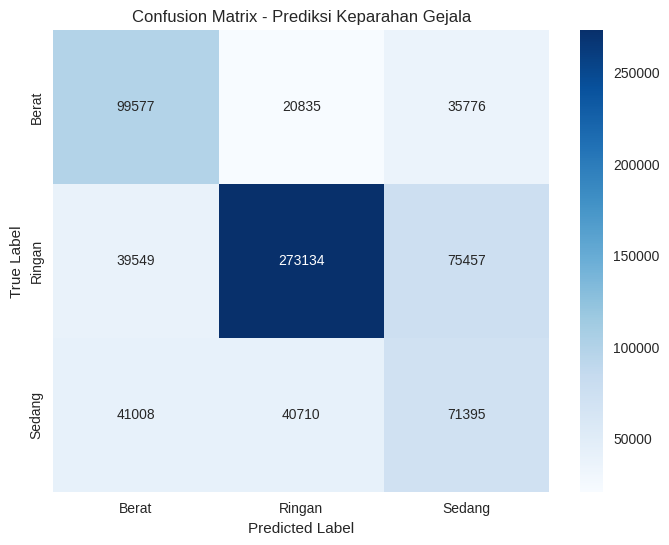

In [ ]:
from imblearn.over_sampling import SMOTE
# ===== 6. MODELING - CLASSIFICATION =====
print("\n🤖 MEMBANGUN MODEL KLASIFIKASI")
print("="*45)

# Split data
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

print(f"✅ Data split - Train: {len(X_train):,}, Test: {len(X_test):,}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_class)

# Train Random Forest Classifier
print("🌳 Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_classifier.fit(X_train, y_train_class)

# Predictions
y_pred_class = rf_classifier.predict(X_test)

# Evaluation
train_accuracy = rf_classifier.score(X_train, y_train_class)
test_accuracy = rf_classifier.score(X_test, y_test_class)

print(f"🎯 Training Accuracy: {train_accuracy:.4f}")
print(f"🎯 Testing Accuracy: {test_accuracy:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test_class, y_pred_class))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Berat', 'Ringan', 'Sedang'],
            yticklabels=['Berat', 'Ringan', 'Sedang'])
plt.title('Confusion Matrix - Prediksi Keparahan Gejala')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# prompt: Udah saya balance udah saya ginikan udah saya gitukan recall Dan precision untuk kelas berat Dan sedang masih kecil loh

import pandas as pd
import matplotlib.pyplot as plt
# Lanjutan dari kode sebelumnya...

# ===== 6. MODELING - CLASSIFICATION =====
print("\n🤖 MEMBANGUN MODEL KLASIFIKASI")
print("="*45)

# Split data
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

print(f"✅ Data split - Train: {len(X_train):,}, Test: {len(X_test):,}")

# Apply SMOTE only on the training data
print("🧬 Menerapkan SMOTE pada data training...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_class)

print(f"Data training setelah SMOTE - Shape X: {X_train_balanced.shape}, Shape y: {y_train_balanced.shape}")
print("Distribusi kelas setelah SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Train Random Forest Classifier with balanced data
print("\n🌳 Training Random Forest Classifier dengan data balanced (SMOTE)...")
# rf_classifier = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=15,
#     min_samples_split=10,
#     min_samples_leaf=5,
#     # class_weight='balanced', # SMOTE handles balancing, so 'balanced' might not be needed *in addition*
#     random_state=42,
#     n_jobs=-1
# )
#
# rf_classifier.fit(X_train_balanced, y_train_balanced)

# Optional: Hyperparameter Tuning with GridSearchCV
print("\n✨ Melakukan Hyperparameter Tuning (GridSearchCV)...")

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # You can experiment with class_weight here as well, but SMOTE often replaces the need for it
    # 'class_weight': ['balanced', None]
}

# Initialize GridSearchCV
# Use scoring that considers class imbalance, like 'f1_weighted' or 'recall_weighted'
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1_weighted', # or 'recall_weighted'
    cv=3, # Cross-validation folds
    n_jobs=-1, # Use all available cores
    verbose=2
)

# Fit GridSearchCV on the SMOTEd training data
grid_search.fit(X_train_balanced, y_train_balanced)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score (F1 weighted): {grid_search.best_score_:.4f}")

# Get the best estimator
rf_classifier_tuned = grid_search.best_estimator_

# Predictions on the original (un-SMOTEd) test set
print("\n📊 Mengevaluasi model pada test set (tidak di-SMOTE)...")
y_pred_class_tuned = rf_classifier_tuned.predict(X_test)

# Evaluation of the tuned model
train_accuracy_tuned = rf_classifier_tuned.score(X_train_balanced, y_train_balanced)
test_accuracy_tuned = rf_classifier_tuned.score(X_test, y_test_class)

print(f"🎯 Training Accuracy (tuned model on SMOTEd data): {train_accuracy_tuned:.4f}")
print(f"🎯 Testing Accuracy (tuned model on original test data): {test_accuracy_tuned:.4f}")

print("\n📋 Classification Report (tuned model):")
print(classification_report(y_test_class, y_pred_class_tuned))

# Confusion Matrix (tuned model)
plt.figure(figsize=(8, 6))
cm_tuned = confusion_matrix(y_test_class, y_pred_class_tuned)
# Use the actual labels from the test set for plotting order
labels_order = sorted(y_test_class.unique())
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title('Confusion Matrix - Prediksi Keparahan Gejala (Tuned Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature Importance from the tuned model
print("\n📈 Feature Importance (Tuned Model):")
feature_importances = pd.Series(rf_classifier_tuned.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x=feature_importances_sorted.head(15).values, y=feature_importances_sorted.head(15).index)
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("✅ Modeling klasifikasi selesai.")